In [3]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('data/news/dataset.csv')


#keep only the columns we need - title and date
df = df[['Title', 'Date']]

# Display the first few rows of the DataFrame
print(df.at[210, 'Title'])

Coronavirus outbreak: Consolidation in PSB space now a reality


In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter the DataFrame for dates between 2018 and 2020
filtered_df = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2020-12-31')]

# Display the first few rows of the filtered DataFrame
filtered_df.head()

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('filtered_dataset.csv', index=False)

# Display the shape of the filtered DataFrame
print(filtered_df.shape)

(4726, 2)


In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

sentences = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results = nlp(sentences)
print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative


C:\Users\shubham\AppData\Roaming\Python\Python311\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


[{'label': 'Negative', 'score': 0.9966173768043518}, {'label': 'Positive', 'score': 1.0}, {'label': 'Negative', 'score': 0.9999710321426392}, {'label': 'Neutral', 'score': 0.9889442920684814}]


In [ ]:
# Analyze sentiment for each news title in the filtered DataFrame
filtered_df['Sentiment'] = filtered_df['Title'].apply(lambda x: nlp(x)[0]['label'])
filtered_df['Sentiment_Score'] = filtered_df['Title'].apply(lambda x: nlp(x)[0]['score'])

# Display the first few rows of the updated DataFrame
filtered_df.head()

In [7]:
filtered_df.to_csv('filtered_dataset_with_sentiment.csv', index=False)

In [ ]:
import openai

# Set up your OpenAI API key
openai.api_key = 'your-api-key-here'

# Define a function to get a response from OpenAI API
def get_openai_response(prompt):
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=100
    )
    return response.choices[0].text.strip()

# Loop over the top 10 headlines in the DataFrame
for headline in df['Title'].head(10):
    prompt = f"""
    Extract the following features from the news headline:
    1. Named Entities
    2. Topic
    3. Sector/Industry
    4. Financial Metrics
    5. Tone

    Headline: "{headline}"
    """
    response = get_openai_response(prompt)
    print(f"Headline: {headline}\nResponse: {response}\n")

| **News** | **Sentiment** | **Named Entities** | **Topic** | **Sector/Industry** | **Financial Metrics** | **Tone** |
|-------------------------------------------|----------------|-----------------------------|-------------------------|------------------------|--------------------------|------------------|
| NBFC yields yet to show contraction...    | Neutral        | NBFC, Govt                  | Spreads                  | Finance                 | None                     | Neutral          |
| Sitharaman gives liquidity boost...       | Positive       | Sitharaman, Shadow Banks, MFIs | Liquidity Boost         | Finance                 | Rs 75,000 cr             | Optimistic       |
| Kotak Bank profit before tax slips...     | Negative       | Kotak Bank                  | Earnings Report          | Banking                 | 10.6% decrease, Rs 2,674 cr | Cautionary    |
| Differentiated bank holdco norms...       | Positive       | Bandhan, IDFC First          | Regulation Change        | Banking                 | None                     | Optimistic       |
| Bad bank may start with Rs 60K-crore...   | Neutral        | Bad Bank, Govt               | NPA Management           | Banking                 | Rs 60K-crore NPAs         | Neutral          |
| Some MSMEs may need deep restructuring... | Negative       | MSMEs, Union Bank            | Restructuring            | Finance                 | None                     | Cautionary       |
| IBA considering proposal to set up...     | Positive       | IBA, PSBs                   | NPA Management           | Banking                 | None                     | Optimistic       |
| Not offering any emergency loan...        | Neutral        | SBI, YONO                   | Clarification            | Banking                 | None                     | Neutral          |


In [15]:
import requests
import json



# Gemini API key
# api_key = ""
second_key=""

# The endpoint URL
url = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent?key={second_key}"

# generates the content
def fetch_features(news):
  # The message to be sent to the model
    prompt = f"""
    

    "Analyze the following financial news headline: {news}."

    Based on this headline, extract the following structured information as a tuple, choosing each feature from its predefined categories:

    1. **Company**: Identify the primary company mentioned"
    2. **Event**: Identify the main event or action, choosing from: "Merger," "New Product," "Profit/Loss Announcement," "Partnership/Collaboration," "Policy Change."
    3. **Reason**: Identify the reason for the event, choosing from: "Market Demand," "Regulatory Requirement," "Internal Strategy," "External Competition," "Economic Conditions."
    4. **Verdict**: Assess the likely impact on stock, choosing from: "UP," "DOWN," "NEUTRAL."

    NOTE: give categories from the categories provided in the prompt. DO NOT EXPLAIN THE CATEGORIES or output. Also, try to reason out the answer based on the headline see if the news might have any impact on the stock price of the company mentioned in the headline. DO NOT OUTPUT ANYTHING ELSE OTHER THEN THE TUPLE. DO NOT SAY - " Here's the structured information extracted from the headlines:"

    **Return the information in tuple format** only and nothing else using the example format below:

    Example format:
    `("Company", "Event", "Reason", "Verdict")`

        """

  # Headers and data{headline}
    headers = {
        "Content-Type": "application/json"
    }

    data = {
        "contents": [
            {
                "parts": [
                    {
                        "text": prompt
                    },
                ]
            }
        ]
    }

    # Make the POST request
    response = requests.post(url, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
            response_json = response.json()
            # print(response_json)
            return response_json



In [37]:
# Fetch features for the top 5 news headlines
top_5_headlines = df['Title'].head(5)

for headline in top_5_headlines:
    response = fetch_features(headline)
    result = response["candidates"][0]['content']['parts'][0]['text']
    print(f"Headline: {headline}\nResult: {result}\n")

Headline: ATMs to become virtual bank branches, accept deposits with instant credit
Result: (`None`, `Policy Change`, `None`, `Market Demand`, `NEUTRAL`) 


Headline: IDFC First Bank seniors to forgo 65% of bonus amid Covid-19 crisis
Result: ("IDFC First Bank", "Policy Change", "50-75%", "Economic Conditions", "DOWN") 


Headline: Huge scam in YES Bank for many years, says Enforcement Directorate
Result: ("YES Bank", "Profit/Loss Announcement", "NEUTRAL", "Internal Strategy", "DOWN") 


Headline: Bank of Maharashtra sanctioned Rs 2,789 cr in loans to MSMEs in 3 months
Result: ("Bank of Maharashtra", "New Product", ">100%", "Internal Strategy", "NEUTRAL") 


Headline: DCB Bank's profit before tax declines 37.6% to Rs 93.84 crore in Q4
Result: ("DCB Bank", "Profit/Loss Announcement", "75-100%", "Economic Conditions", "DOWN") 




In [11]:
import ast
from time import sleep

sentiment_df = pd.read_csv('data/news/sentiment_with_features.csv')
sentiment_df.head()

,Date,Daily_Sentiment,News,Event,Reason,Verdict
0,2020-03-22,Neutral,An opportunity in Covid-19 crisis: Revisit all...,NaN,NaN,NaN
1,2020-03-23,Neutral,RBI extends priority sector classification for...,NaN,NaN,NaN
2,2020-03-24,Neutral,Writedown of YES Bank's additional AT-I bonds ...,NaN,NaN,NaN
3,2020-03-25,Neutral,Coronavirus: Banks offer fresh lines of credit...,NaN,NaN,NaN
4,2020-03-26,Neutral,ESAF Small Finance Bank gets Sebi approval to ...,NaN,NaN,NaN


In [ ]:


# Add the following columns to the DataFrame to store the extracted features
sentiment_df['Event'] = '' 
sentiment_df['Reason'] = ''
sentiment_df['Verdict'] = ''

# Loop over the DataFrame and extract features for each news headline
for index, row in sentiment_df.iterrows():
    # print(index)
    # if(index < 155) :
    #     continue
    if index % 15 == 0:
        sleep(60)
    response = fetch_features(row['News'])
    if response and "candidates" in response and response["candidates"]:
        result = response["candidates"][0]['content']['parts'][0]['text']
        #sample result: ("Apple", "New Product", "25-50%", "Market Demand", "UP")
        result = result.replace('`', "'")
        features = ast.literal_eval(result)
        print(index)
        sentiment_df.at[index, 'Event'] = features[1]
        sentiment_df.at[index, 'Reason'] = features[2]
        sentiment_df.at[index, 'Verdict'] = features[3]
        #append the row to a new csv file
        sentiment_df.to_csv('data/news/sentiment_with_features.csv', index=False)
    else:
        print(f"Error fetching features for headline: {row['News']}")

# Display the first few rows of the updated DataFrame
sentiment_df.head()



In [3]:
import pandas as pd

sentiment_df = pd.read_csv('data/news/features_news.csv')
sentiment_df.head()

,Date,Daily_Sentiment,News,Event,Reason,Verdict
0,2018-01-01,Neutral,Odisha turns to banking outlets to cover untap...,Partnership/Collaboration,Internal Strategy,UP
1,2018-01-02,Neutral,"Min balance row: SBI breaks silence, says it w...",Policy Change,Regulatory Requirement,NEUTRAL
2,2018-01-03,Neutral,RBI puts Allahabad Bank under prompt correctiv...,Policy Change,Regulatory Requirement,DOWN
3,2018-01-04,Neutral,Rs 200-note recalibration: ATM operators see R...,Merger,Internal Strategy,DOWN
4,2018-01-05,Neutral,Indian Overseas Bank plans to write off its lo...,Profit/Loss Announcement,Internal Strategy,NEUTRAL


In [4]:


# 2. **Event**: Identify the main event or action, choosing from: "Merger," "New Product," "Profit/Loss Announcement," "Partnership/Collaboration," "Policy Change."
#     3. **Reason**: Identify the reason for the event, choosing from: "Market Demand," "Regulatory Requirement," "Internal Strategy," "External Competition," "Economic Conditions."
#     4. **Verdict**: Assess the likely impact on stock, choosing from: "UP," "DOWN," "NEUTRAL."

# Convert the text fields into categorical fields
sentiment_df['Event'] = sentiment_df['Event'].astype('category')
sentiment_df['Reason'] = sentiment_df['Reason'].astype('category')
sentiment_df['Verdict'] = sentiment_df['Verdict'].astype('category')

# Create a mapping for each categorical field to numerical categories
event_mapping = {category: code for code, category in enumerate(sentiment_df['Event'].cat.categories)}
reason_mapping = {category: code for code, category in enumerate(sentiment_df['Reason'].cat.categories)}
verdict_mapping = {category: code for code, category in enumerate(sentiment_df['Verdict'].cat.categories)}

# Map the categorical fields to numerical categories
sentiment_df['Event'] = sentiment_df['Event'].cat.codes
sentiment_df['Reason'] = sentiment_df['Reason'].cat.codes
sentiment_df['Verdict'] = sentiment_df['Verdict'].cat.codes

# Display the mappings
print("Event Mapping:", event_mapping)
print("Reason Mapping:", reason_mapping)
print("Verdict Mapping:", verdict_mapping)

# Display the first few rows of the updated DataFrame
sentiment_df.head()


#save the updated dataframe to a new csv file
sentiment_df.to_csv('data/news/news_categorical.csv', index=False)

Event Mapping: {'"': 0, 'Cyber Hack': 1, 'Economic Conditions': 2, 'Internal Strategy': 3, 'Legal Action': 4, 'Legal Issue': 5, 'Merger': 6, 'New Product': 7, 'Partnership/Collaboration': 8, 'Policy Change': 9, 'Profit/Loss Announcement': 10, 'Regulatory Requirement': 11, 'Stake Sale': 12, 'y': 13}
Reason Mapping: {'Bad Loans': 0, 'Economic Conditions': 1, 'External Competition': 2, 'Internal Strategy': 3, 'Market Demand': 4, 'Policy Change': 5, 'Regulatory Requirement': 6, 'S': 7, 't': 8}
Verdict Mapping: {'B': 0, 'DOWN': 1, 'NEUTRAL': 2, 'UP': 3, 'h': 4}


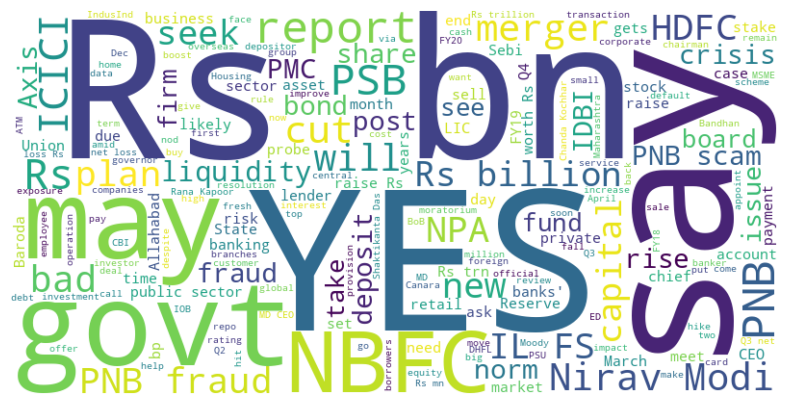

In [52]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all titles into a single string
all_titles = ' '.join(sentiment_df['Title'])

#remove stopwords
all_titles = ' '.join([word for word in all_titles.split() if word.lower() not in STOPWORDS])

# Define the top 20 common and most frequent words to remove
top_20_words = {'bank', 'banks', 'rbi', 'sbi', 'loan', 'loans', 'credit', 'rate', 'rates', 'cr', 'crore', 'india', 'indian', 'finance', 'financial', 'lending', 'growth', 'fiscal', 'year', 'quarter', 'profit'}

# Update the STOPWORDS set with the top 20 words
stopwords = STOPWORDS.union(top_20_words)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(all_titles)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## After filtering merge the news for each day

In [64]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('data/news/sentiment.csv')

# Display the first few rows of the DataFrame
df.head()

,Title,Date,Sentiment,Sentiment_Score
0,"ATMs to become virtual bank branches, accept d...",2020-05-26,Neutral,0.999943
1,IDFC First Bank seniors to forgo 65% of bonus ...,2020-05-26,Neutral,0.951466
2,"Huge scam in YES Bank for many years, says Enf...",2020-05-25,Neutral,0.996678
3,"Bank of Maharashtra sanctioned Rs 2,789 cr in ...",2020-05-24,Neutral,0.995092
4,DCB Bank's profit before tax declines 37.6% to...,2020-05-23,Negative,0.999972


In [65]:
from collections import Counter

# Assuming df is already defined and contains the necessary data
# Group by 'Date' and aggregate the sentiments
grouped_df = df.groupby('Date')['Sentiment'].apply(lambda x: ', '.join(x)).reset_index()

# Function to determine the most common sentiment for a given list of sentiments
def most_common_sentiment(sentiments):
    return Counter(sentiments.split(', ')).most_common(1)[0][0]

# Apply the function to the 'Sentiment' column
grouped_df['Daily_Sentiment'] = grouped_df['Sentiment'].apply(most_common_sentiment)

#concatenate the news titles for each date
grouped_df['News'] = df.groupby('Date')['Title'].apply(lambda x: ', '.join(x)).reset_index()['Title']

# Display the first few rows of the updated DataFrame
grouped_df.head(20)

# Drop the sentiment column
grouped_df = grouped_df.drop(columns=['Sentiment'])

# Save the updated DataFrame to a new CSV file
grouped_df.to_csv('daily_sentiment.csv', index=False)

In [ ]:
# Find the missing dates in the DataFrame
missing_dates = pd.date_range(start=grouped_df['Date'].min(), end=grouped_df['Date'].max()).difference(grouped_df['Date'])
print(missing_dates)

# Create a DataFrame for the missing dates with the most common sentiment
most_common_sentiment = grouped_df['Daily_Sentiment'].mode()[0]
missing_dates_df = pd.DataFrame({'Date': missing_dates, 'Daily_Sentiment': most_common_sentiment})

# Concatenate the missing dates DataFrame with the grouped DataFrame
updated_grouped_df = pd.concat([grouped_df, missing_dates_df]).sort_values(by='Date').reset_index(drop=True)

# Display the first few rows of the updated DataFrame
updated_grouped_df.head(20)

In [1]:
import pandas as pd

sentiment_df = pd.read_csv("data/news/sentiment.csv")

sentiment_df.head()

,Title,Date,Sentiment,Sentiment_Score
0,"ATMs to become virtual bank branches, accept d...",2020-05-26,Neutral,0.999943
1,IDFC First Bank seniors to forgo 65% of bonus ...,2020-05-26,Neutral,0.951466
2,"Huge scam in YES Bank for many years, says Enf...",2020-05-25,Neutral,0.996678
3,"Bank of Maharashtra sanctioned Rs 2,789 cr in ...",2020-05-24,Neutral,0.995092
4,DCB Bank's profit before tax declines 37.6% to...,2020-05-23,Negative,0.999972


In [2]:
hdfc_news = sentiment_df[sentiment_df['Title'].str.contains('BANDHAN', case=False, na=False)]
print(len(hdfc_news))
hdfc_news.head()


47


,Title,Date,Sentiment,Sentiment_Score
32,Differentiated bank holdco norms on cards; Ban...,2020-05-12,Positive,1.000000
121,Singapore's Caladium ups stake at Bandhan Bank...,2020-04-21,Neutral,0.999900
161,Deposits from microbanking customers continue ...,2020-04-13,Positive,1.000000
163,Bandhan Bank's FY20 deposits rise 32%; 60% jum...,2020-04-13,Positive,0.999996
342,Bandhan Bank to invest Rs 300 cr in Yes Bank a...,2020-03-14,Neutral,0.999934


In [3]:
hdfc_stock_price = pd.read_csv("data/stock_technical_data/BANDHANBNK.NS.csv")
hdfc_stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_9,SMA_21,EMA_9,...,BB_lower,ADX,ADX+DI,ADX-DI,CMF,OBV,CCI,Williams_%R,ATR,Target
0,2018-05-16,0.559236,0.554612,0.586057,0.570050,0.567925,0.002861,0.585881,0.602040,0.583005,...,0.663570,0.200428,0.172455,0.450032,0.422976,0.465822,0.384836,0.184596,0.191134,1
1,2018-05-17,0.564669,0.558252,0.590868,0.572398,0.570273,0.003220,0.581358,0.600014,0.581280,...,0.661303,0.216754,0.184323,0.415375,0.451710,0.466938,0.419720,0.212285,0.181895,0
2,2018-05-18,0.561251,0.554872,0.591503,0.564919,0.562796,0.001749,0.578099,0.597669,0.578192,...,0.658233,0.231325,0.172521,0.389953,0.460234,0.466249,0.412500,0.129456,0.168128,0
3,2018-05-21,0.548896,0.548197,0.564633,0.546221,0.544103,0.002303,0.572529,0.594209,0.571452,...,0.651371,0.275079,0.144780,0.556645,0.456286,0.465399,0.340443,0.098437,0.180577,1
4,2018-05-22,0.539783,0.541609,0.573348,0.548917,0.546799,0.001338,0.568551,0.591854,0.566676,...,0.646009,0.314389,0.131627,0.515524,0.481218,0.465969,0.377317,0.139998,0.172416,1


/tmp/ipykernel_40051/3916961634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hdfc_news['Date'] = pd.to_datetime(hdfc_news['Date'])


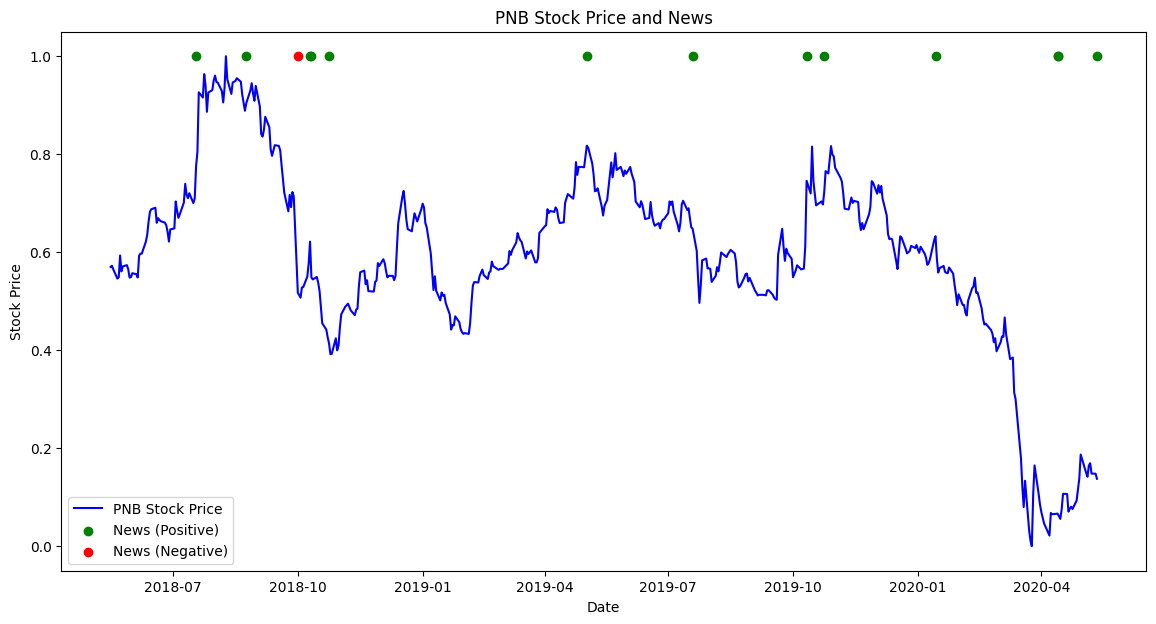

In [4]:
import matplotlib.pyplot as plt

# Convert the 'Date' columns to datetime format if not already done
hdfc_stock_price['Date'] = pd.to_datetime(hdfc_stock_price['Date'])
hdfc_news['Date'] = pd.to_datetime(hdfc_news['Date'])

# Find the common time frame
start_date = max(hdfc_stock_price['Date'].min(), hdfc_news['Date'].min())
end_date = min(hdfc_stock_price['Date'].max(), hdfc_news['Date'].max())

# Filter the dataframes to the common time frame
filtered_stock_price = hdfc_stock_price[(hdfc_stock_price['Date'] >= start_date) & (hdfc_stock_price['Date'] <= end_date)]
filtered_news = hdfc_news[(hdfc_news['Date'] >= start_date) & (hdfc_news['Date'] <= end_date)]

# Define colors for sentiments
sentiment_colors = {'Positive': 'green' ,'Negative': 'red'}

# Plot the stock prices
plt.figure(figsize=(14, 7))
plt.plot(filtered_stock_price['Date'], filtered_stock_price['Close'], label='PNB Stock Price', color='blue')

# Plot the news as points colored by sentiment
for sentiment in sentiment_colors:
    sentiment_news = filtered_news[filtered_news['Sentiment'] == sentiment]
    plt.scatter(sentiment_news['Date'], [filtered_stock_price['Close'].max()] * len(sentiment_news), 
                color=sentiment_colors[sentiment], label=f'News ({sentiment})', marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('PNB Stock Price and News')
plt.legend()

# Show the plot
plt.show()

In [5]:
# Merge the filtered_stock_price and filtered_news DataFrames on the 'Date' column
merged_df = pd.merge(filtered_stock_price, filtered_news[['Date', 'Sentiment']], on='Date', how='left')

# Initialize variables
initial_amount = 1000
amount = initial_amount
shares = 0

# Define the trading strategy
def trading_strategy(row, amount, shares):
    if row['Sentiment'] == 'Positive' and amount > 0:
        # Buy shares
        shares_to_buy = amount / row['Close']
        amount -= shares_to_buy * row['Close']
        shares += shares_to_buy
    elif row['Sentiment'] == 'Negative' and shares > 0:
        # Sell shares
        amount += shares * row['Close']
        shares = 0
    return amount, shares

# Apply the trading strategy over the 3-year period
for index, row in merged_df.iterrows():
    if row['Date'] >= start_date and row['Date'] <= end_date:
        amount, shares = trading_strategy(row, amount, shares)

# Calculate the final amount
final_amount = amount + shares * merged_df.iloc[-1]['Close']

# Print the results
print(f"Initial Amount: {initial_amount}")
print(f"Final Amount after 3 years: {final_amount}")
print(f"Profit: {final_amount - initial_amount}")

Initial Amount: 1000
Final Amount after 3 years: 147.78111777216722
Profit: -852.2188822278328


In [6]:

banks = {
    'AUBANK': 'AU Small Finance Bank',
    'BANKBARODA': 'Bank of Baroda',
    'KOTAKBANK': 'Kotak Mahindra Bank',
    'BANDHANBNK': 'Bandhan Bank',
    'SBIN': 'State Bank of India',
    'HDFCBANK': 'HDFC Bank',
    'INDUSINDBK': 'IndusInd Bank',
    'AXISBANK': 'Axis Bank',
    'PNB': 'Punjab National Bank',
    'ICICIBANK': 'ICICI Bank',
    'FEDERALBNK': 'Federal Bank',
    'IDFCFIRSTB': 'IDFC First Bank'
}

Processing file: data/stock_technical_data/AUBANK.NS.csv
Processing file: data/stock_technical_data/BANKBARODA.NS.csv
Processing file: data/stock_technical_data/KOTAKBANK.NS.csv
Processing file: data/stock_technical_data/BANDHANBNK.NS.csv
Processing file: data/stock_technical_data/SBIN.NS.csv


/tmp/ipykernel_40051/3292374100.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_news['Date'] = pd.to_datetime(stock_news['Date'])
/tmp/ipykernel_40051/3292374100.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_news['Date'] = pd.to_datetime(stock_news['Date'])
/tmp/ipykernel_40051/3292374100.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Processing file: data/stock_technical_data/HDFCBANK.NS.csv
Processing file: data/stock_technical_data/INDUSINDBK.NS.csv
Processing file: data/stock_technical_data/AXISBANK.NS.csv


/tmp/ipykernel_40051/3292374100.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_news['Date'] = pd.to_datetime(stock_news['Date'])
/tmp/ipykernel_40051/3292374100.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_news['Date'] = pd.to_datetime(stock_news['Date'])
/tmp/ipykernel_40051/3292374100.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Processing file: data/stock_technical_data/PNB.NS.csv
Processing file: data/stock_technical_data/ICICIBANK.NS.csv
Processing file: data/stock_technical_data/FEDERALBNK.NS.csv
Processing file: data/stock_technical_data/IDFCFIRSTB.NS.csv


/tmp/ipykernel_40051/3292374100.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_news['Date'] = pd.to_datetime(stock_news['Date'])
/tmp/ipykernel_40051/3292374100.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_news['Date'] = pd.to_datetime(stock_news['Date'])
/tmp/ipykernel_40051/3292374100.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

                   Stock  Initial Amount  Final Amount      Profit
0         Bank of Baroda            1000    609.647377 -390.352623
1    Kotak Mahindra Bank            1000   1691.029280  691.029280
2           Bandhan Bank            1000    148.341254 -851.658746
3    State Bank of India            1000   1444.777232  444.777232
4              HDFC Bank            1000    311.912165 -688.087835
5          IndusInd Bank            1000      7.409383 -992.590617
6              Axis Bank            1000   1019.167041   19.167041
7   Punjab National Bank            1000    455.339939 -544.660061
8             ICICI Bank            1000    929.278210  -70.721790
9           Federal Bank            1000   1567.105113  567.105113
10       IDFC First Bank            1000   1353.125977  353.125977


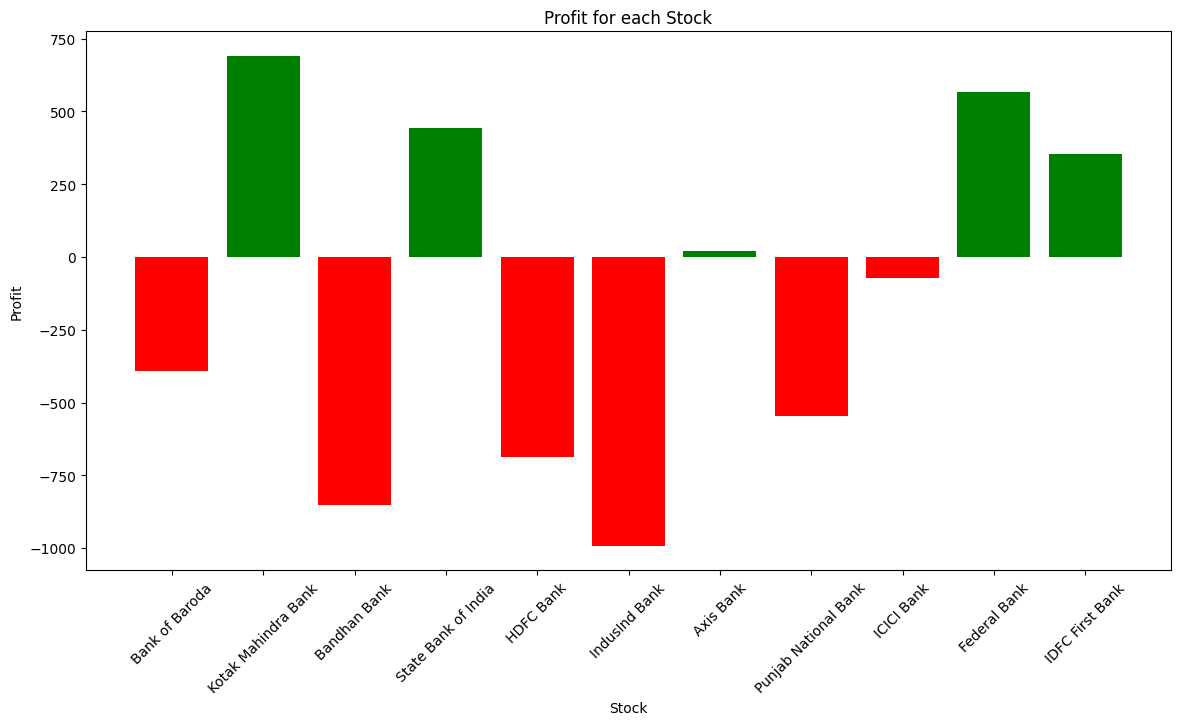

In [7]:
import os
import pandas as pd
from collections import Counter
from datetime import datetime

import matplotlib.pyplot as plt

# Define the directory containing the stock data files
stock_data_dir = "data/stock_technical_data"

# Define a function to process each stock file
def process_stock_file(file_path):
    stock_df = pd.read_csv(file_path)
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    
    # Filter the news data for the specific stock
    stock_name = os.path.basename(file_path).split('.')[0]
    stock_name_key = os.path.basename(file_path).split('.')[0]
    stock_name = banks.get(stock_name_key, stock_name_key)
    stock_news = sentiment_df[sentiment_df['Title'].str.contains(stock_name, case=False, na=False)]
    if stock_news.empty:
        return None
    
    # Ensure 'Date' columns are in datetime format
    stock_news['Date'] = pd.to_datetime(stock_news['Date'])
    
    # Merge the stock data with the news data
    merged_df = pd.merge(stock_df, stock_news[['Date', 'Sentiment']], on='Date', how='left')
    
    # Initialize variables
    initial_amount = 1000
    amount = initial_amount
    shares = 0

    # Define the trading strategy
    def trading_strategy(row, amount, shares):
        if row['Sentiment'] == 'Positive' and amount > 0:
            # Buy shares
            shares_to_buy = amount / row['Close']
            amount -= shares_to_buy * row['Close']
            shares += shares_to_buy
        elif row['Sentiment'] == 'Negative' and shares > 0:
            # Sell shares
            amount += shares * row['Close']
            shares = 0
        return amount, shares

    # Apply the trading strategy over the period
    for index, row in merged_df.iterrows():
        amount, shares = trading_strategy(row, amount, shares)

    # Calculate the final amount
    final_amount = amount + shares * merged_df.iloc[-1]['Close']
    profit = final_amount - initial_amount
    return {
        'Stock': stock_name,
        'Initial Amount': initial_amount,
        'Final Amount': final_amount,
        'Profit': profit
    }

# Process all stock files in the directory
results = []
for file_name in os.listdir(stock_data_dir):
    file_path = os.path.join(stock_data_dir, file_name)
    print(f"Processing file: {file_path}")
    result = process_stock_file(file_path)
    # print(result)
    if result:
        results.append(result)

# Convert the results to a DataFrame and display it
results_df = pd.DataFrame(results)
print(results_df)

# Plot the profits for each stock
plt.figure(figsize=(14, 7))
colors = ['green' if profit > 0 else 'red' for profit in results_df['Profit']]
plt.bar(results_df['Stock'], results_df['Profit'], color=colors)
plt.xlabel('Stock')
plt.ylabel('Profit')
plt.title('Profit for each Stock')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Calculate the net profit
net_profit = results_df['Profit'].sum()

# Print the net profit
print(f"Net Profit: {net_profit}")

Net Profit: -1462.8670287177135
